# Network Gaussian example N=10

## Setup and packages

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic("reset","-f")

from PyPackageJonas import *

graphics_path = "C:/Users/jonas/Git/Analysis-of-Production-flow-systems-with-focus-on-industry/Latex Thesis/figures/ND examples/Network Gaussian 10"

In [2]:
N = 10
Rho = np.zeros((N,N))

Rho[0,1] = 0.7

Rho[4,5] = 0.5

Rho[1,6] = 0.3
Rho[5,6] = 0.3

Rho[5,7] = 0.7

Rho[3,8] = 0.3
Rho[7,8] = 0.3

Rho[6,9] = 0.4
Rho[8,9] = 0.2

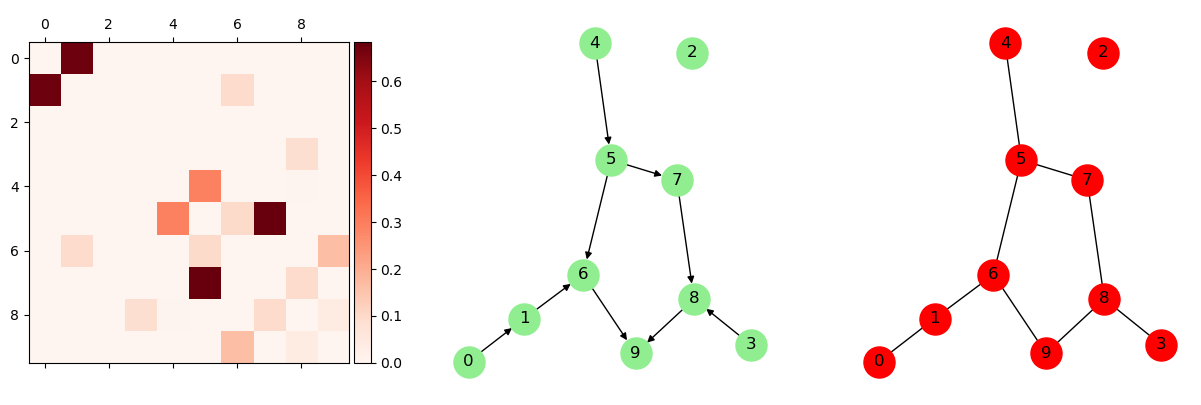

In [3]:
ConvolvedInformation = Rho + Rho.T
ConvolvedInformation = -1/2*np.log(1-ConvolvedInformation**2)
ConvolvedInformation = ConvolvedInformation @ np.linalg.pinv(np.identity(N) - ConvolvedInformation)

DeconvoledInformation = ND(ConvolvedInformation,alpha = 1)


fig, ax = plt.subplots(1,3,figsize=(15,5))


r = ax.flat[0].matshow(DeconvoledInformation, cmap = "Reds", vmin = 0)
divider = make_axes_locatable(ax.flat[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax);


# Directed graph from initial correlation structure (non-symmetric)
am = Rho.copy()
am[am > 0] = 1
np.fill_diagonal(am,0)
gr = nx.from_numpy_array(am, create_using = nx.DiGraph)

nx.draw(gr, pos=graphviz_layout(gr), node_size = 500, with_labels= True, ax = ax.flat[1], node_color='lightgreen')


am = DeconvoledInformation.copy()
t = 0.01
am[am > t] = 1
am[am < t] = 0
np.fill_diagonal(am,0)
gr = nx.from_numpy_array(am)

nx.draw(gr, pos=graphviz_layout(gr), node_size = 500, with_labels= True, ax = ax.flat[2], node_color='red')

## Data sampling

In [4]:
A = np.zeros((N,N))

for i in range(N):
    sum_ = (Rho[:,i]**2).sum()
    A[i,:] = (Rho[:,i][:,None] * A).sum(axis=0)
    A[i,i] = np.sqrt(1- sum_)

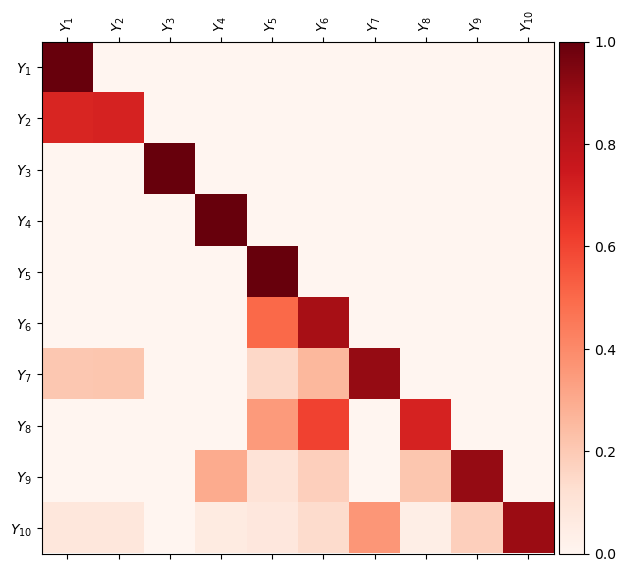

In [5]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
r = ax.matshow(A, cmap = "Reds")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(r, cax=cax)

ax.set_xticks([x for x in range(N)], GenLabels("Y", N), rotation='vertical');
ax.set_yticks([x for x in range(N)], GenLabels("Y", N));

In [6]:
n_sample = 10_000
mean = np.zeros(N)

Z = np.random.default_rng().multivariate_normal(mean = mean, cov = np.identity(N), size = n_sample).T
Y = (A @ Z)

## $G_{obs}$

In [7]:
# Prepare Kernels, transformed data to uniform (from kernel), Scott's optimal bandwiths
kernels_Y = [gaussian_kde(Y[i,:]) for i in tqdm(range(N))]

U = np.vstack( [np.array([kernels_Y[i].integrate_box_1d(-np.inf, x_i) for x_i in Y[i,:]]) for i in tqdm(range(N)) ])
kernels_U = [gaussian_kde(U[i,:]) for i in tqdm(range(N))]

h = np.array([(kernels_Y[i].covariance**0.5)[0,0] for i in tqdm(range(N))])

100%|██████████| 10/10 [00:00<?, ?it/s]


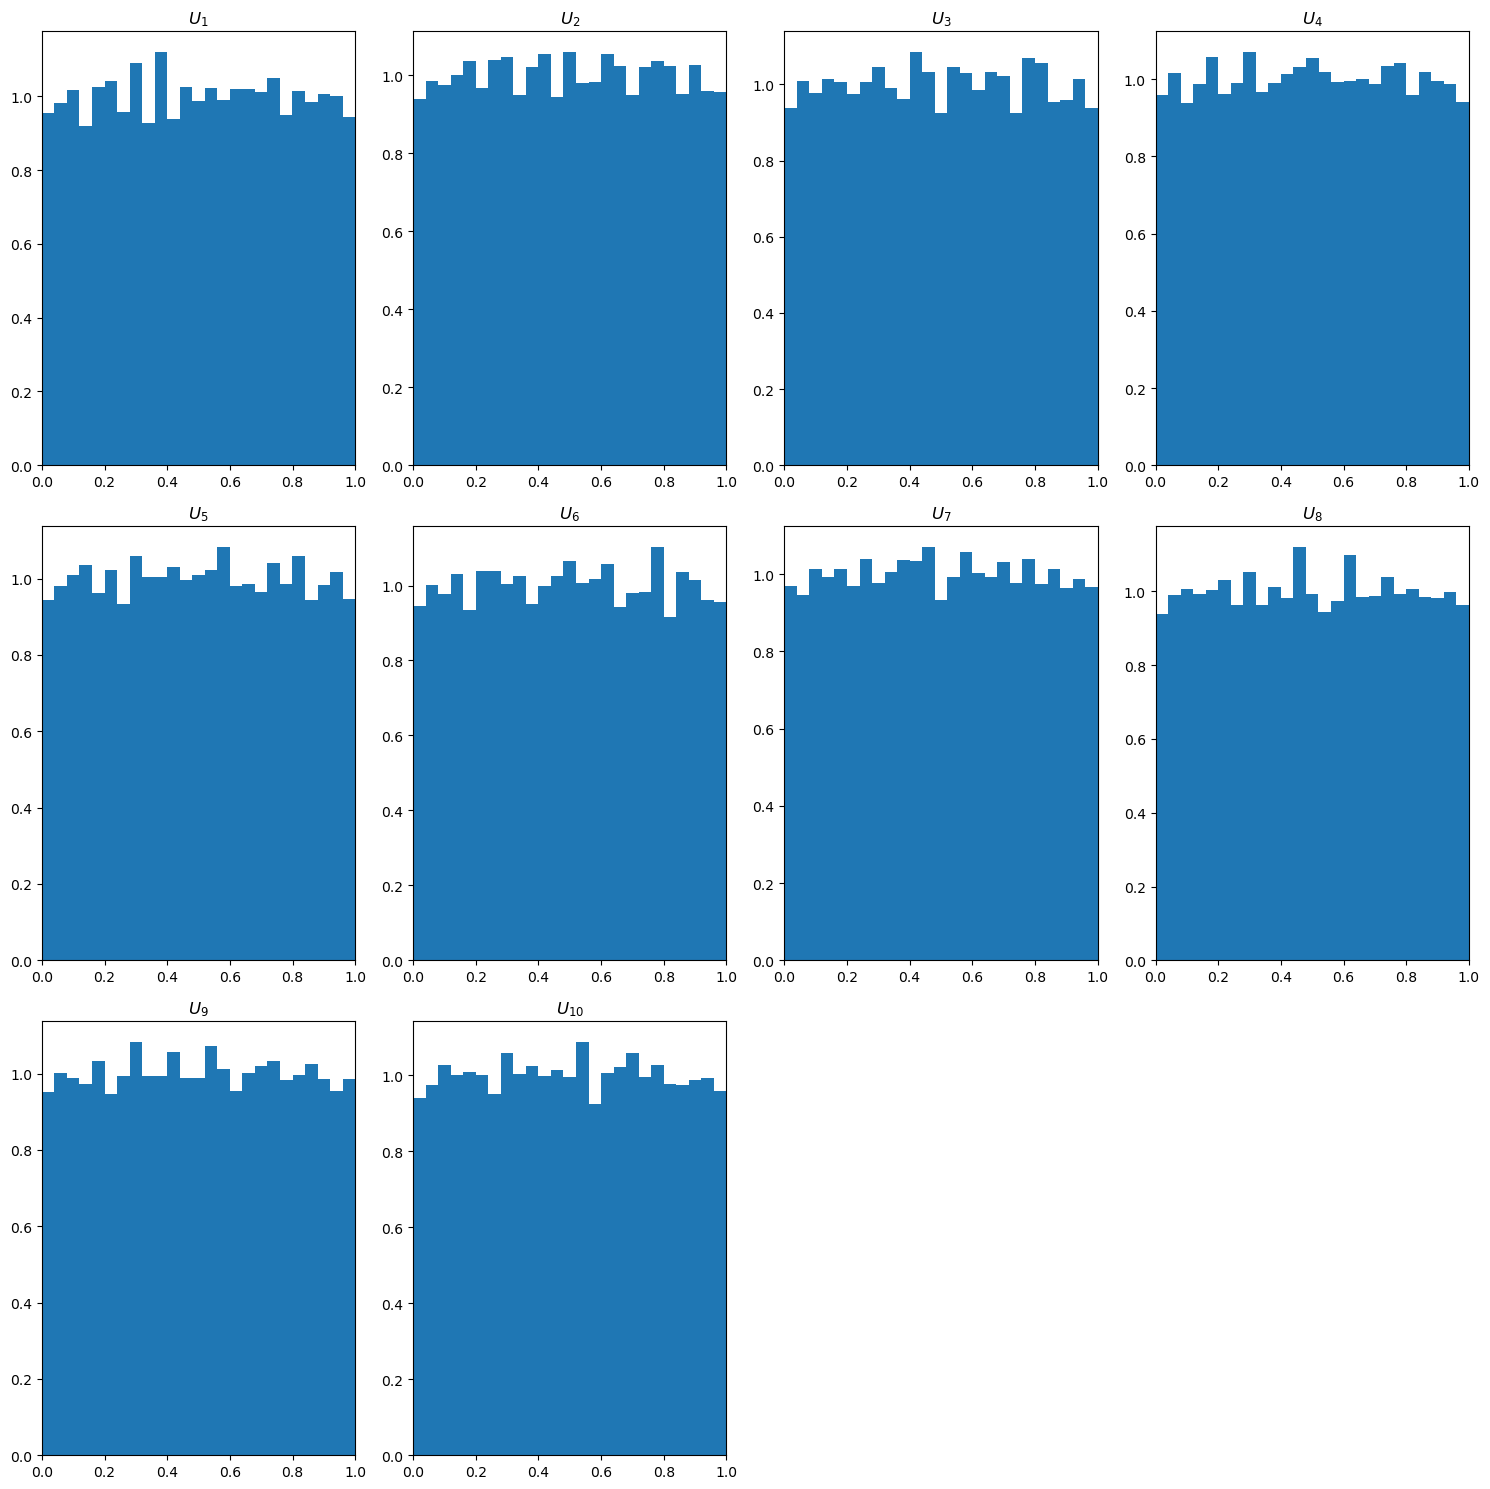

In [8]:
n_cols = int(np.ceil(np.sqrt(N)))
n_rows = int(np.ceil(N / n_cols))
fig, ax = plt.subplots(n_rows,n_cols, figsize=(15,15))

for i in range(N):
    ax.flat[i].hist(U[i,:], density=True, bins = 25)
    ax.flat[i].set_title("$U_{" +f"{i+1}" + "}$")
    ax.flat[i].set_xlim([0,1])

for i in range(N,n_rows*n_cols):
    ax.flat[i].axis("off")

fig.tight_layout()

In [9]:
try:
    with open('Example Network Gaussian 10 GObs.pkl', 'rb') as f:
        G_obs = pickle.load(f)
except:
    G_obs = np.zeros((N,N))
    count = 0
    for i in range(N-1):
        u_i = U[i,:]
        for j in range(i+1, N):
            print(f"{ count } / { (N*(N-1)/2) :3.0f}    [{100*count/ (N*(N-1)/2) :7.2f}%]    ({i}, {j})\033[K", end ="\r")

            u_j = U[j,:]

            kernel_ij = gaussian_kde(np.vstack([u_i,u_j]))

            d_vol = kernel_ij.integrate_box(
                    low_bounds = [0,0],
                    high_bounds = [1,1]
                )
            
            # Simple normalization of KDE such that integrates to 1 (no jackknifing)
            G_obs[i,j] = G_obs[j,i] = \
                dblquad(
                    lambda x,y : 
                        kernel_ij.pdf(np.vstack([x,y])) * \
                        kernel_ij.logpdf(np.vstack([x,y])),
                    0,1,
                    0,1
                )[0] / d_vol - np.log(d_vol)

            count += 1
            print(f"{ count } / { (N*(N-1)/2) :3.0f}    [{100*count/ (N*(N-1)/2) :7.2f}%]    ({i}, {j})\033[K", end ="\r")
        
    with open('Example Network Gaussian 10 GObs.pkl', 'wb') as f:
        pickle.dump(G_obs, f)

In [10]:
i,j = 0,1
u_i, u_j = U[i,:], U[j,:]
kernel_ij = gaussian_kde(np.vstack([u_i,u_j]))
n_mesh = 100
Y1v, Y2v = np.meshgrid(
    np.linspace(0,1,n_mesh), 
    np.linspace(0,1,n_mesh))

Zv = np.reshape(kernel_ij.evaluate(np.vstack([Y1v.ravel(), Y2v.ravel()])), (n_mesh,n_mesh))

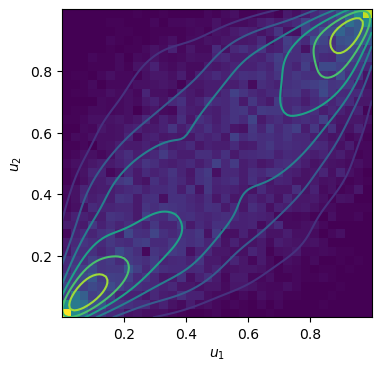

In [11]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.contour(Y1v, Y2v, Zv );
ax.set_xlabel("$u_1$")
ax.set_ylabel("$u_2$")

res = plt.hist2d(u_i, u_j, density=True, bins = (35,35));

In [12]:
u_i.min()

8.519519387231943e-05

In [13]:
(res[1][1:] - res[1][:-1]).min()**2 * np.nan_to_num(res[0] * np.log(res[0])).sum()

C:\Users\jonas\AppData\Local\Temp\ipykernel_20076\2978230862.py:1: RuntimeWarning: divide by zero encountered in log
  (res[1][1:] - res[1][:-1]).min()**2 * np.nan_to_num(res[0] * np.log(res[0])).sum()
C:\Users\jonas\AppData\Local\Temp\ipykernel_20076\2978230862.py:1: RuntimeWarning: invalid value encountered in multiply
  (res[1][1:] - res[1][:-1]).min()**2 * np.nan_to_num(res[0] * np.log(res[0])).sum()


0.38774103798615334

In [14]:
r = range(20,100)
E = np.zeros(r.__len__())
for idx, n_bins in enumerate(r):


    res = np.histogram2d(u_i, u_j, density=True, bins = (n_bins,n_bins))

    # plt.matshow(res[0])

    # plt.matshow(np.imag(np.fft.fft2(res[0])))


    fft_res = np.fft.fft2(res[0])
    rows, cols = fft_res.shape
    crow, ccol = rows // 2, cols // 2

    fft_percent_radius = 0.7
    fft_radius = int(min(crow, ccol) * (1-fft_percent_radius) )

    fft_shift_res = np.fft.fftshift(fft_res)
    fft_shift_res[crow - fft_radius:crow + fft_radius, ccol - fft_radius:ccol + fft_radius] = 0

    fft_shift_res_inv = np.fft.ifftshift(fft_shift_res)
    mod_fft = np.fft.ifft2(fft_shift_res_inv)



    # imag_fft = np.imag(fft_res)
    # real_fft = np.real(fft_res)
    # q = np.quantile(np.abs(imag_fft).ravel(), 0.6)
    # # q = 2
    # real_fft[np.abs(imag_fft) > q] = 0
    # # imag_fft[np.abs(imag_fft) > q] = 0


    # mod_fft = real_fft + imag_fft

    # ifft_res = np.fft.ifft2(mod_fft)

    # plt.matshow(np.real(ifft_res))
    # plt.matshow(np.imag(ifft_res))



    E[idx] = np.abs(np.abs(mod_fft) - res[0]).mean()

    # plt.matshow(np.abs(mod_fft))

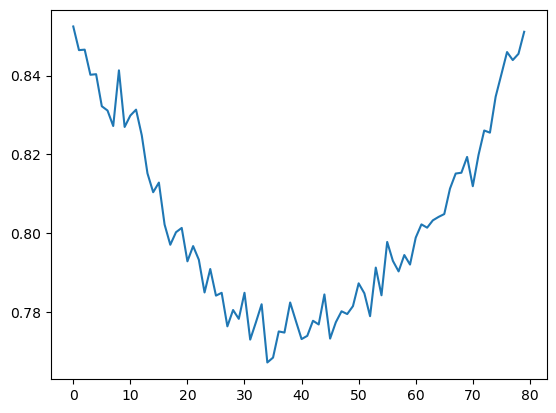

In [15]:
plt.plot(E)

C:\Users\jonas\AppData\Local\Temp\ipykernel_20076\2104005326.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(xx,np.nan_to_num(np.log(xx)*xx))
C:\Users\jonas\AppData\Local\Temp\ipykernel_20076\2104005326.py:2: RuntimeWarning: invalid value encountered in multiply
  plt.plot(xx,np.nan_to_num(np.log(xx)*xx))


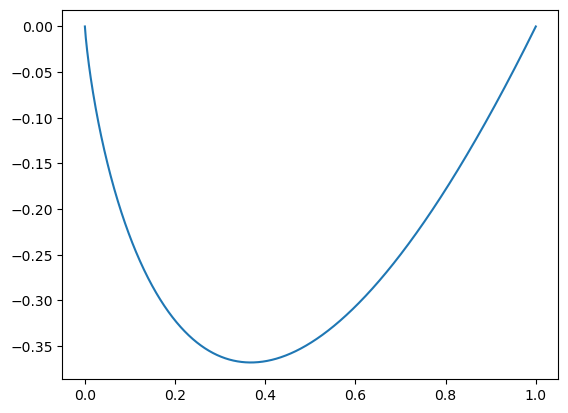

In [16]:
xx = np.linspace(0,1,1000)
plt.plot(xx,np.nan_to_num(np.log(xx)*xx))

In [17]:
np.quantile(np.abs(np.imag(np.fft.fft2(res[0]))).ravel(), 0.95)

141.64894996960203

In [34]:
n_mesh = 100
uu1, uu2 = np.meshgrid(
    np.linspace(1/(2*n_mesh),1 - 1/(2*n_mesh),n_mesh),
    np.linspace(1/(2*n_mesh),1 - 1/(2*n_mesh),n_mesh)
)

In [35]:

pdfij = kernel_ij.evaluate(np.vstack([uu1.ravel(), uu2.ravel()]))
pdfij_log = kernel_ij.logpdf(np.vstack([uu1.ravel(), uu2.ravel()]))

In [36]:
vol = 1/n_mesh**2 * pdfij.sum()
MI = 1/n_mesh**2 * (pdfij * pdfij_log).sum() / vol - np.log(vol)

MI

# 100: 0.27505222880680286
# 200: 0.27509714064787716

0.27505222880680286

In [37]:
G_obs[i,j]

0.2725824834476379

In [29]:
G_obs_theoretical[i,j]

0.3468470533388382

In [85]:
res[1]

array([1.23038018e-04, 5.00036519e-01, 9.99950000e-01])

In [94]:
np.where( (u_i < 0.5) & (u_i > 0) & (u_j < 0.5) & (u_j > 0) )[0].__len__()

3724

In [96]:
np.where( (u_i > 0.5) & (u_i < 1) & (u_j > 0.5) & (u_j < 1) )[0].__len__()

3726

In [97]:
np.where( (u_i > 0.5) & (u_i < 1) & (u_j < 0.5) & (u_j > 0) )[0].__len__()

1268

In [99]:
log = np.where( (u_i < 0.5) & (u_i > 0) & (u_j < 0.5) & (u_j > 0) )[0]

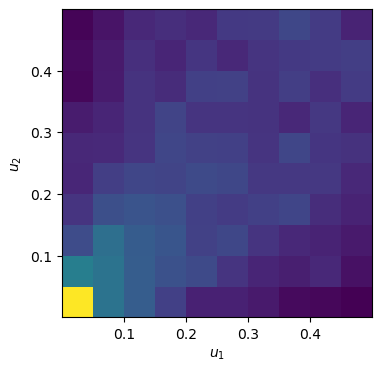

In [101]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.set_xlabel("$u_1$")
ax.set_ylabel("$u_2$")

res = plt.hist2d(u_i[log], u_j[log], density=True, bins = (10,10));

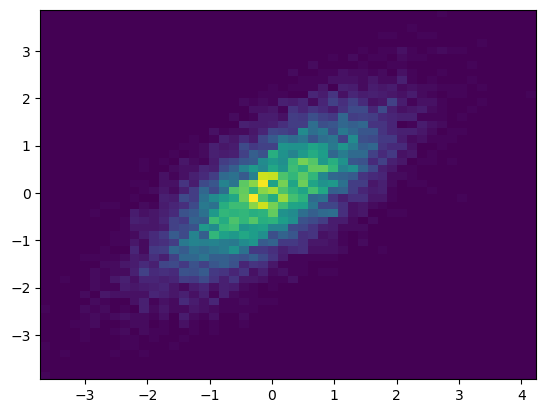

In [45]:
res = plt.hist2d(Y[i,:],Y[j,:], density=True, bins = (50,50));

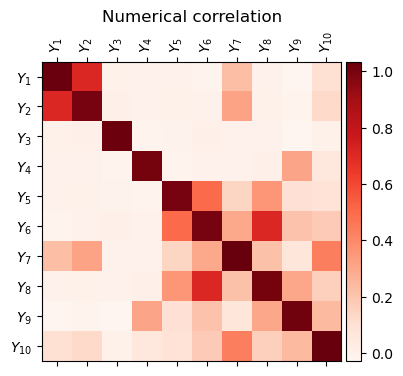

In [20]:
num_corr = np.cov(Y)

fig, ax = plt.subplots(1,1,figsize=(4,4))
r = ax.matshow(num_corr, cmap = "Reds")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax);
fig.tight_layout()
ax.set_title("Numerical correlation")
VariableMatrixSetLabels(ax, N, "Y")

plt.savefig(graphics_path + "/Numerical Correlation", bbox_inches='tight')
plt.savefig(graphics_path + "/Numerical Correlation.pdf", bbox_inches='tight')

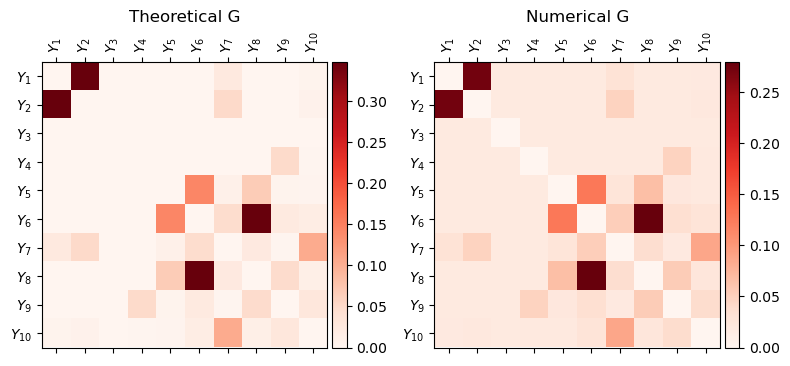

In [21]:
temp = num_corr.copy()
np.fill_diagonal(temp,0)
G_obs_theoretical = -1/2*np.log(1-temp**2)

fig, ax = plt.subplots(1,2,figsize=(8,4))

# Theoretical G
r = ax.flat[0].matshow(G_obs_theoretical, cmap = "Reds")
divider = make_axes_locatable(ax.flat[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax)
VariableMatrixSetLabels(ax.flat[0], N, "Y")
ax.flat[0].set_title("Theoretical G")

# Numerically optained G
r = ax.flat[1].matshow(G_obs, cmap = "Reds")
divider = make_axes_locatable(ax.flat[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax)
VariableMatrixSetLabels(ax.flat[1], N, "Y")
ax.flat[1].set_title("Numerical G")
fig.tight_layout()

plt.savefig(graphics_path + "/GObs theoretical and numerical comparisson", bbox_inches='tight')
plt.savefig(graphics_path + "/GObs theoretical and numerical comparisson.pdf", bbox_inches='tight')

## $G_{dir}$

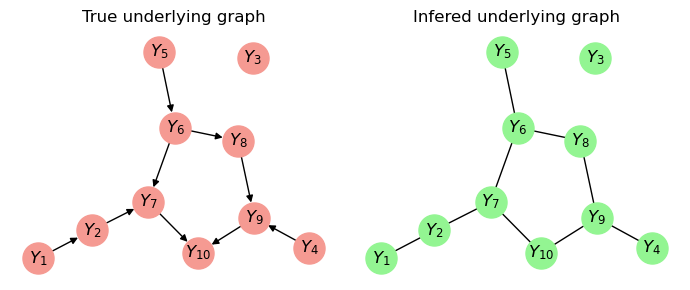

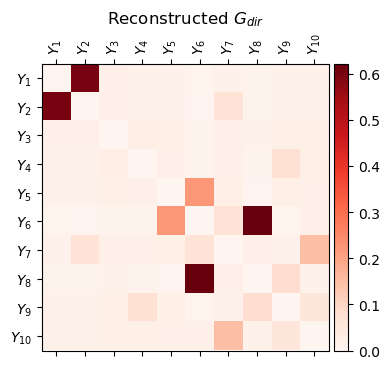

In [44]:
G_dir = ND(G_obs, alpha=1)
# G_dir = ND(G_obs_theoretical, alpha=1)


# Ground truth result
fig, ax = plt.subplots(1,2, figsize=(7,3))
am = Rho.copy()
am[am > 0] = 1
np.fill_diagonal(am,0)
gr = nx.from_numpy_array(am, create_using = nx.DiGraph)
pos = graphviz_layout(gr)
nx.draw(gr, pos=pos, node_size = 500, with_labels= True, ax = ax.flat[0], node_color='#F59A92', labels = { k:v for (k,v) in zip(range(N), GenLabels("Y", N))} )
ax.flat[0].set_title("True underlying graph")


am = G_dir.copy()
t = 0.05
am[am > t] = 1
am[am < t] = 0
np.fill_diagonal(am,0)
gr = nx.from_numpy_array(am)
pos = graphviz_layout(gr)
nx.draw(gr, pos = pos, node_size = 500, with_labels= True, ax = ax.flat[1], node_color='#93F592', labels = { k:v for (k,v) in zip(range(N), GenLabels("Y", N))} )
ax.flat[1].set_title("Infered underlying graph")

for a in ax.flat:
    a.patch.set_linewidth(10)
    a.patch.set_edgecolor('pink')

fig.tight_layout()

plt.savefig(graphics_path + "/underlying graphs comparisson", bbox_inches='tight')
plt.savefig(graphics_path + "/underlying graphs comparisson.pdf", bbox_inches='tight')



fig, ax = plt.subplots(1,1,figsize=(4,4))
r = ax.matshow(G_dir, cmap = "Reds", vmin=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_title("Reconstructed " + "$G_{dir}$")
VariableMatrixSetLabels(ax, N, "Y")
plt.colorbar(r, cax=cax)
fig.tight_layout()
plt.savefig(graphics_path + "/Reconstructed GDir", bbox_inches='tight');
plt.savefig(graphics_path + "/Reconstructed GDir.pdf", bbox_inches='tight');

{0: '$Y_{1}$',
 1: '$Y_{2}$',
 2: '$Y_{3}$',
 3: '$Y_{4}$',
 4: '$Y_{5}$',
 5: '$Y_{6}$',
 6: '$Y_{7}$',
 7: '$Y_{8}$',
 8: '$Y_{9}$',
 9: '$Y_{10}$'}